# Swin Transformer for Chest X-Ray Classification
## Computer Vision — A.Y. 2024/25

**Task:** Binary classification of chest X-ray images (*Normal* vs *Pneumonia*)

**Models:**

| Configuration | Window size | Attention type | Complexity (attention) |
|:---|:---:|:---|:---|
| **Swin-T (W7)** | 7 × 7 | Local (shifted windows) | $\mathcal{O}(n)$ — linear in image size |
| **Swin-T (W14)** | 14 × 14 | Larger local windows | $\mathcal{O}(n)$ — linear, higher constant |
| **Swin-T (W56)** | 56 × 56 | Global (full image = one window) | $\mathcal{O}(n^2)$ — quadratic in image size |

All models share the Swin-Tiny backbone (≈ 28 M params), differ only in window size, and are evaluated on 224 × 224 px images.
More info regarding the fine-tuning phase, like hyperparameters or training logs, could be found inside ./output directory.

**Training setup:** 50 epochs, AdamW with cosine-annealing LR, batch size 32 for all models, standard (unweighted) cross-entropy loss.

**Evaluation metrics:** accuracy, balanced accuracy, sensitivity, specificity, precision, f1-score, ROC/AUC, VRAM memory, inference latency.

**Source code & training configs:** [GitHub — ma3ti/Swin-transformer-ChestXray](https://github.com/ma3ti/Swin-transformer-ChestXray/tree/main/finetune)

**Fine tuned Models Gdrive Link:** [Swin FineTuned Models](https://drive.google.com/drive/folders/1IxqllikqeIXZS0StSciBQRVs573VFeoA?usp=sharing)

**Swin Transformer Paper:** [Swin Transformer](https://arxiv.org/pdf/2103.14030)


---
## 1. Environment Setup

In [ ]:
import os
import sys
import time
import re
import warnings
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

plt.rcParams.update({
    "figure.dpi": 120,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "legend.fontsize": 10,
    "font.family": "serif",
})
sns.set_style("whitegrid")

warnings.filterwarnings("ignore", category=FutureWarning)

print(f"PyTorch {torch.__version__}")

PyTorch 2.5.1


In [ ]:
# ── Distributed-training env vars (required by Swin config loader) ───
os.environ.update({
    "LOCAL_RANK": "0",
    "WORLD_SIZE": "1",
    "MASTER_ADDR": "localhost",
    "MASTER_PORT": "12345",
})

sys.path.append(os.path.abspath(".."))

from config import get_config
from models import build_model

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    _hw = torch.cuda.get_device_name(0)
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    _hw = "Apple Metal (MPS)"
else:
    DEVICE = torch.device("cpu")
    _hw = "CPU"

print(f"Device: {DEVICE}  ({_hw})")

Device: mps  (Apple Metal (MPS))


---
## 2. Configuration & Paths

In [46]:
# ── Paths ────────────────────────────────────────────────────────────
TEST_DIR = "../dataset/chest_xray_new/test"
IMAGE_DIR = "./Images/"

MODEL_CONFIGS = {
    "Swin-T (W7)": {
        "cfg": "../configs/swin/chest_xray_finetune.yaml",
        "ckpt": "output/swin_w7/swin7.pth",
        "log": "output/swin_w7/log_rank0.txt",
        "color": "#3b82f6", 
    },
    "Swin-T (W14)": {
        "cfg": "../configs/swin/chest_xray_finetune14.yaml",
        "ckpt": "output/swin_w14/swin14.pth",
        "log": "output/swin_w14/log_rank0.txt",
        "color": "#22c55e",  
    },
    "Swin-T (W56)": {
        "cfg": "../configs/swin/chest_xray_vit.yaml",
        "ckpt": "output/swin_w56/swin56.pth",
        "log": "output/swin_w56/log_rank0.txt",
        "color": "#ef4444", 
    },
}


class SwinArgs:
    """Mimics the CLI args expected by ``get_config``."""

    cfg = ""
    opts = ["MODEL.NUM_CLASSES", "2"]
    batch_size = 32
    data_path = ""
    zip = False
    cache_mode = "part"
    pretrained = ""
    resume = ""
    accumulation_steps = 1
    use_checkpoint = False
    amp_opt_level = ""
    output = "output"
    tag = "default"
    eval = True
    throughput = False
    enable_amp = False
    fused_window_process = False
    fused_layernorm = False
    optim = "adamw"
    local_rank = 0


print("Configuration loaded ✓")
for name, info in MODEL_CONFIGS.items():
    exists = ": found" if Path(info["ckpt"]).exists() else "not found"
    print(f"  {name:18s}  checkpoint {exists}")

Configuration loaded ✓
  Swin-T (W7)         checkpoint : found
  Swin-T (W14)        checkpoint : found
  Swin-T (W56)        checkpoint : found


---
## 3. Training History

Parse training logs and visualise training loss, validation loss, and top-1 accuracy across epochs.

> All three models were fine-tuned for **50 epochs** with AdamW, cosine-annealing LR schedule, and **batch size 32**. A standard (unweighted) cross-entropy loss was used (no class weighting) allowing the model to learn the decision boundary naturally from the data distribution.

Due to unblanced dataset in favor of the positive class, this skewdness is kept because it's far better misclassify a negative class as positive than the opposite. Than, more positive class (Pneumonia) helps in this.

In [ ]:
def parse_training_log(file_path: str) -> dict | None:
    """Parse a Swin training log and return per-epoch metrics.

    Targets the epoch-summary lines printed by main.py:
        INFO EPOCH <n> train loss <x>
        INFO Validation Loss: <x>
        INFO  * Acc@1 <x>
        
    Returns
    -------
    dict with keys: epochs, train_loss, val_loss, val_acc
    """
    if not os.path.exists(file_path):
        print(f"\u26a0  Log not found: {file_path}")
        return None

    train_re = re.compile(r"EPOCH (\d+) train loss (\d+\.\d+)")
    val_re   = re.compile(r"Validation Loss:\s*(\d+\.\d+)")
    acc_re   = re.compile(r"\* Acc@1 (\d+\.\d+)")

    data = {"epochs": [], "train_loss": [], "val_loss": [], "val_acc": []}

    with open(file_path) as f:
        for line in f:
            m = train_re.search(line)
            if m:
                data["epochs"].append(int(m.group(1)))
                data["train_loss"].append(float(m.group(2)))
                continue

            m = val_re.search(line)
            if m:
                data["val_loss"].append(float(m.group(1)))
                continue

            m = acc_re.search(line)
            if m:
                data["val_acc"].append(float(m.group(1)))

    n = min(map(len, data.values()))
    if n == 0:
        print(f"\u26a0  No epochs parsed from: {file_path}")
        return None
    return {k: v[:n] for k, v in data.items()}


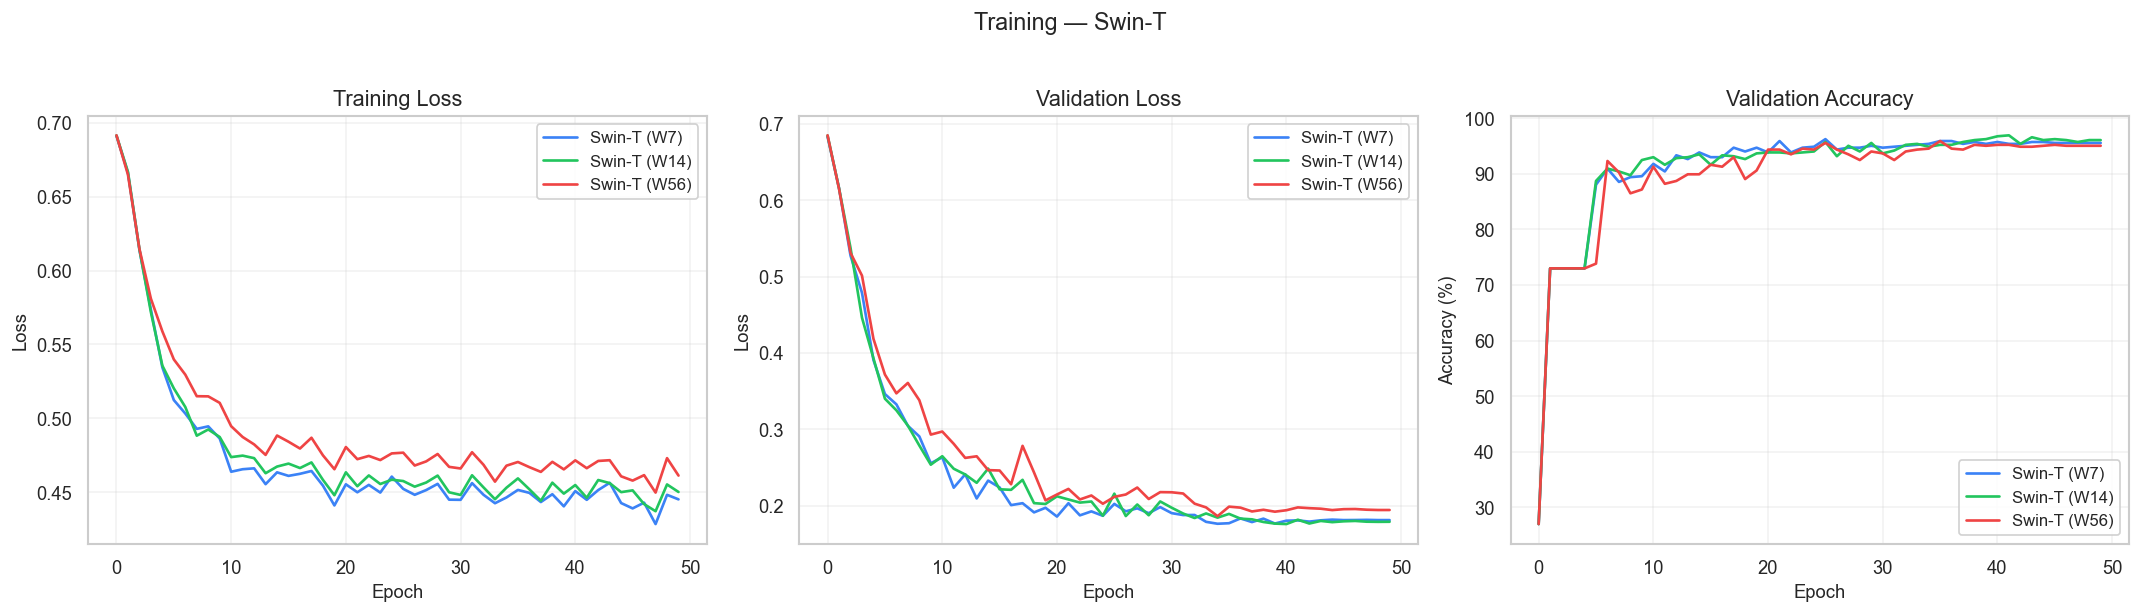

In [ ]:
# Parse all logs 
logs = {}
for name, info in MODEL_CONFIGS.items():
    logs[name] = parse_training_log(info["log"])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
titles  = ["Training Loss", "Validation Loss", "Validation Accuracy"]
y_keys  = ["train_loss", "val_loss", "val_acc"]
y_labels = ["Loss", "Loss", "Accuracy (%)"]

for ax, title, key, ylabel in zip(axes, titles, y_keys, y_labels):
    for name, d in logs.items():
        if d is None:
            continue
        ls = "-"
        ax.plot(d["epochs"], d[key], ls, label=name,
                color=MODEL_CONFIGS[name]["color"], linewidth=1.6)
    ax.set(title=title, xlabel="Epoch", ylabel=ylabel)
    ax.legend(framealpha=0.9)
    ax.grid(True, alpha=0.25)

fig.suptitle("Training — Swin-T", fontsize=14, y=1.02)
fig.tight_layout()
fig.savefig(IMAGE_DIR + "training_history.png", bbox_inches="tight")
plt.show()

---
## 4. Test-Set Evaluation

For each configuration we compute:

| Metric | Formula | Clinical meaning |
|:---|:---|:---|
| **Accuracy** | $\frac{TP + TN}{TP + TN + FP + FN}$ | Overall correctness |
| **Sensitivity (Recall)** | $\frac{TP}{TP + FN}$ | Ability to detect **pneumonia** (positive class) |
| **Specificity** | $\frac{TN}{TN + FP}$ | Ability to correctly identify **normal** cases |
| **Balanced Accuracy** | $\frac{Sensitivity + Specificity}{2}$ | Imbalance-corrected accuracy |

where:
- *positive* = Pneumonia,
- *negative* = Normal.

> **Note on class imbalance:** the test set contains more pneumonia than normal images. Balanced accuracy corrects for this by giving equal weight to both classes. The pneumonia class also merges two visually distinct sub-types:
- **bacterial**  
- **viral** 

These increases intra-class variance and could make pneumonia harder to classify than normal lungs.


In [24]:
def load_test_data(test_dir: str, batch_size: int = 32) -> tuple:
    """Return (DataLoader, class_names) for the test split."""
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    ds = datasets.ImageFolder(root=test_dir, transform=transform)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False,
                        num_workers=4, pin_memory=True)
    print(f"Test set: {len(ds)} images, {len(ds.classes)} classes {ds.classes}")
    print(f"Class mapping: {ds.class_to_idx}  (0 = Negative, 1 = Positive)")
    return loader, ds.classes

In [ ]:
@torch.no_grad()
def evaluate_model(name: str, config_path: str, checkpoint_path: str, test_loader: DataLoader, classes: list[str]) -> dict | None:
    """Load a checkpoint and evaluate it on the test set.

    Returns
    -------
    dict  accuracy, balanced_accuracy, sensitivity, specificity, cm, preds, targets, probs
    """
    print(f"\n{'─'*60}")
    print(f"  Evaluating: {name}")
    print(f"{'─'*60}")

    for p, label in [(config_path, "Config"), (checkpoint_path, "Checkpoint")]:
        if not os.path.exists(p):
            print(f"  ✗ {label} not found: {p}")
            return None

    # Build model
    args = SwinArgs()
    args.cfg = config_path
    config = get_config(args)
    print(f"  Window size: {config.MODEL.SWIN.WINDOW_SIZE}")
    model = build_model(config)

    # Load weights
    ckpt = torch.load(checkpoint_path, map_location="cpu", weights_only=False)
    state_dict = ckpt.get("model", ckpt)
    model.load_state_dict(state_dict, strict=False)
    model.to(DEVICE).eval()

    # Inference
    all_preds, all_targets, all_probs = [], [], []
    for images, targets in tqdm(test_loader, desc=f"  {name}", leave=False):
        images, targets = images.to(DEVICE), targets.to(DEVICE)
        logits = model(images)
        probs  = torch.softmax(logits, dim=1)
        preds  = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())

    preds_np  = np.array(all_preds)
    targets_np = np.array(all_targets)
    cm = confusion_matrix(targets_np, preds_np)
    tn, fp, fn, tp = cm.ravel()

    sens = tp / (tp + fn) if (tp + fn) else 0.0
    spec = tn / (tn + fp) if (tn + fp) else 0.0

    metrics = {
        "accuracy":          (tp + tn) / (tp + tn + fp + fn),
        "balanced_accuracy": (sens + spec) / 2,
        "sensitivity":       sens,
        "specificity":       spec,
        "cm": cm,
        "preds": preds_np,
        "targets": targets_np,
        "probs": np.array(all_probs),
    }
    print(f"  → Accuracy: {metrics['accuracy']:.2%}  |  "
          f"Bal. Acc: {metrics['balanced_accuracy']:.2%}  |  "
          f"Sens: {metrics['sensitivity']:.2%}  |  "
          f"Spec: {metrics['specificity']:.2%}")
    return metrics

In [ ]:
# Run evaluation
test_loader, classes = load_test_data(TEST_DIR)

results = {}
for name, info in MODEL_CONFIGS.items():
    r = evaluate_model(name, info["cfg"], info["ckpt"], test_loader, classes)
    if r is not None:
        results[name] = r

if not results:
    raise RuntimeError("No model could be evaluated: check file paths above.")

Test set: 587 images, 2 classes ['NORMAL', 'PNEUMONIA']
Class mapping: {'NORMAL': 0, 'PNEUMONIA': 1}  (0 = Negative, 1 = Positive)

────────────────────────────────────────────────────────────
  Evaluating: Swin-T (W7)
────────────────────────────────────────────────────────────
=> merge config from ../configs/swin/chest_xray_finetune.yaml
  Window size: 7


  → Accuracy: 93.53%  |  Bal. Acc: 94.18%  |  Sens: 92.76%  |  Spec: 95.60%

────────────────────────────────────────────────────────────
  Evaluating: Swin-T (W14)
────────────────────────────────────────────────────────────
=> merge config from ../configs/swin/chest_xray_finetune14.yaml
  Window size: 14


  → Accuracy: 94.04%  |  Bal. Acc: 94.13%  |  Sens: 93.93%  |  Spec: 94.34%

────────────────────────────────────────────────────────────
  Evaluating: Swin-T (W56)
────────────────────────────────────────────────────────────
=> merge config from ../configs/swin/chest_xray_vit.yaml
  Window size: 56


  → Accuracy: 92.33%  |  Bal. Acc: 92.77%  |  Sens: 91.82%  |  Spec: 93.71%


---
### 4.1. Confusion Matrices

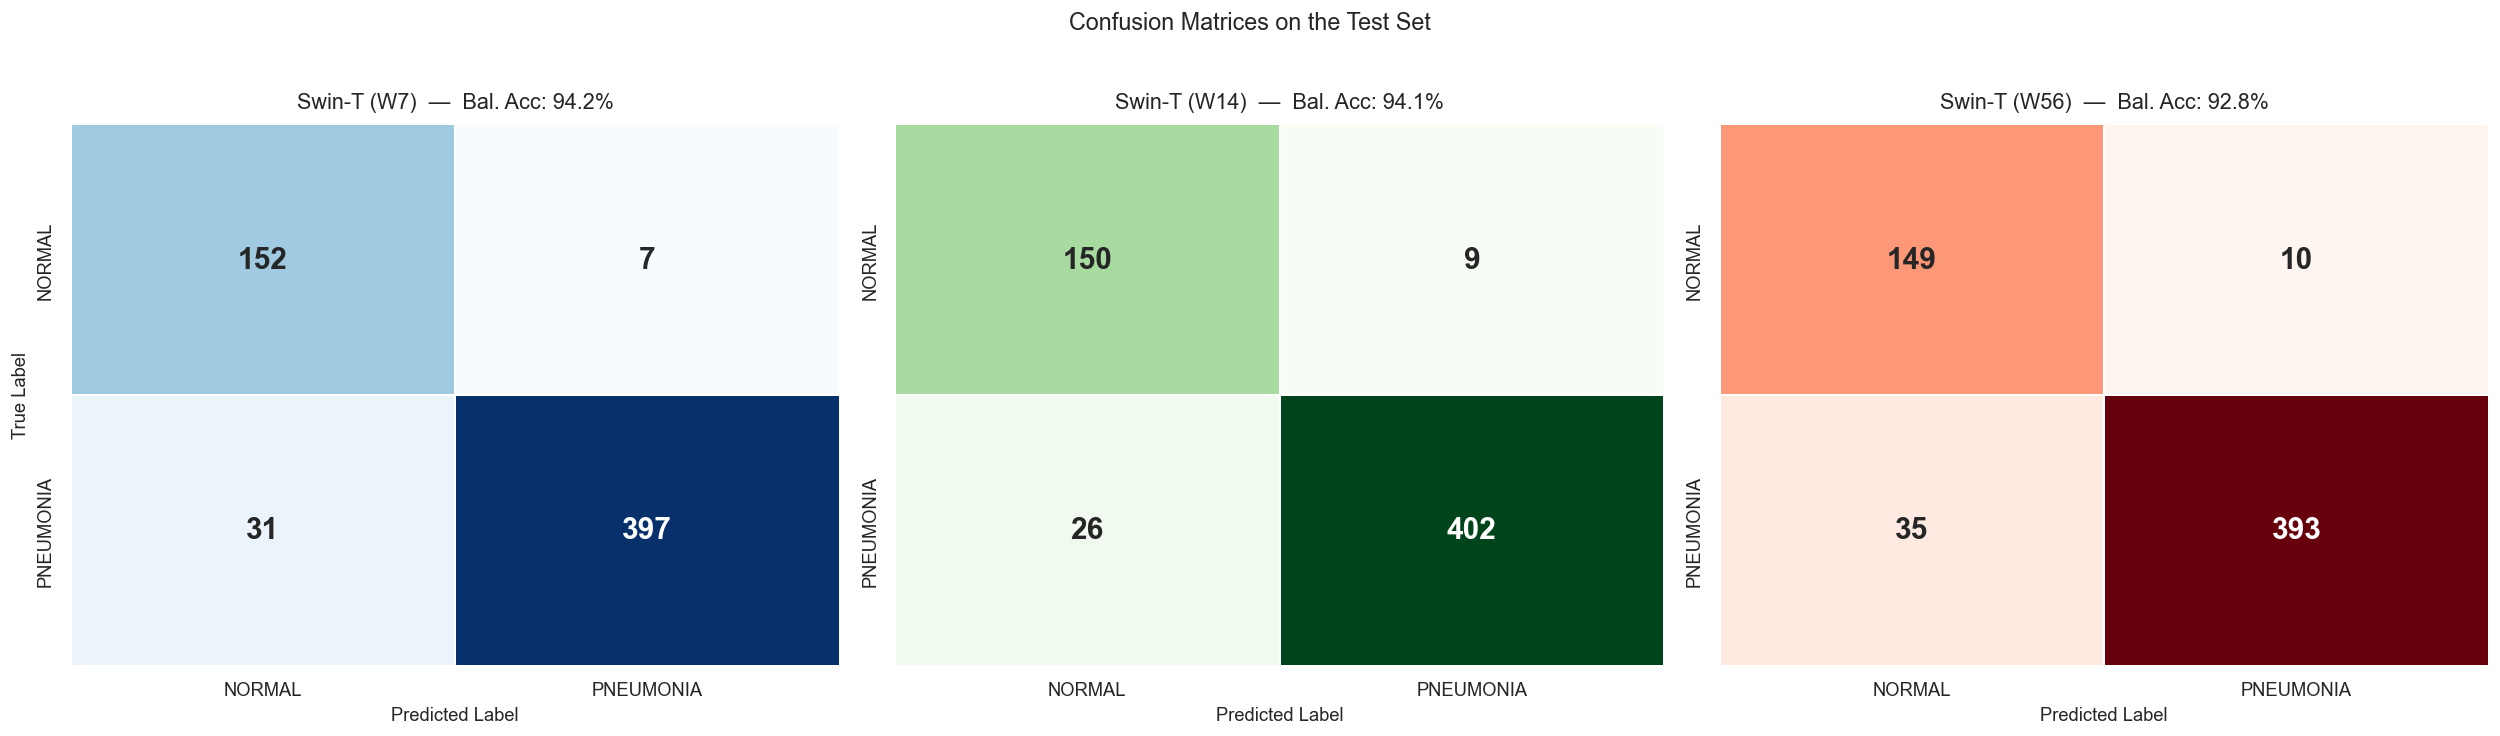

In [27]:
fig, axes = plt.subplots(1, len(results), figsize=(7 * len(results), 6))
if len(results) == 1:
    axes = [axes]

cmaps = {"Swin-T (W7)": "Blues", "Swin-T (W14)": "Greens", "Swin-T (W56)": "Reds"}

for ax, (name, r) in zip(axes, results.items()):
    sns.heatmap(
        r["cm"], annot=True, fmt="d", cmap=cmaps.get(name, "Blues"),
        cbar=False, ax=ax, xticklabels=classes, yticklabels=classes,
        annot_kws={"size": 18, "weight": "bold"},
        linewidths=1.2, linecolor="white",
    )
    acc = r["balanced_accuracy"]
    ax.set_title(f"{name}  —  Bal. Acc: {acc:.1%}", fontsize=13, pad=10)
    ax.set_ylabel("True Label" if ax == axes[0] else "")
    ax.set_xlabel("Predicted Label")

fig.suptitle("Confusion Matrices on the Test Set", fontsize=14, y=1.02)
fig.tight_layout()
fig.savefig(IMAGE_DIR + "confusion_matrices.png", bbox_inches="tight")
plt.show()

### 4.2. Metrics Comparison

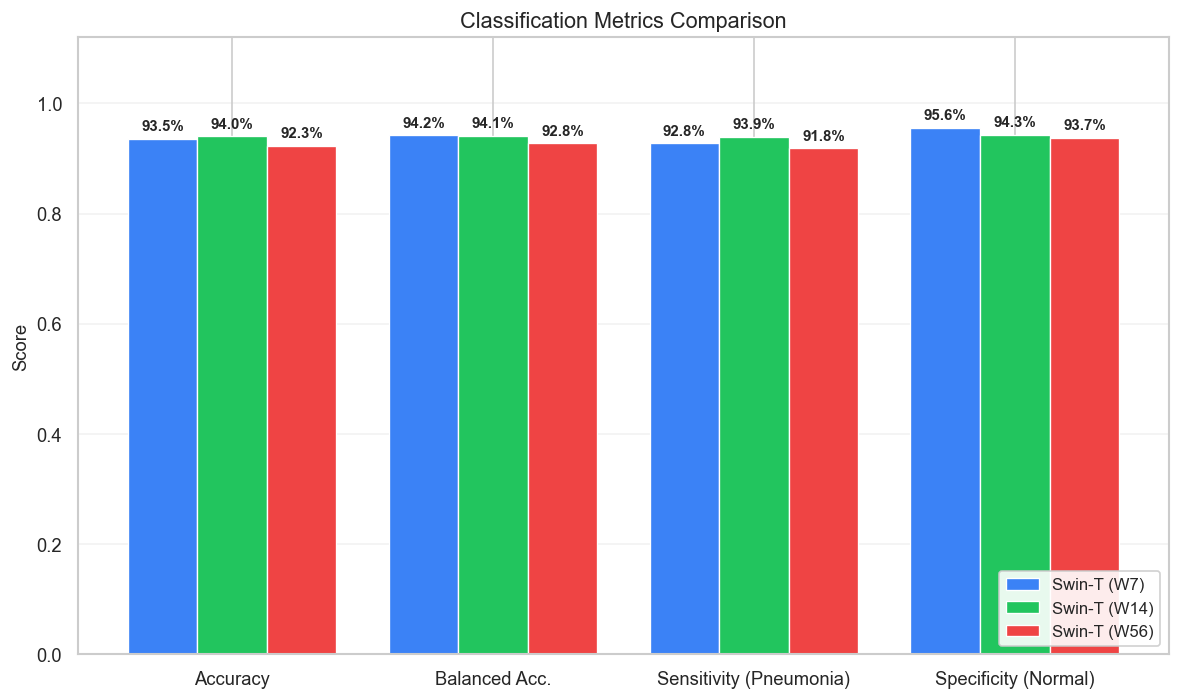

In [28]:
metric_names = ["Accuracy", "Balanced Acc.", "Sensitivity (Pneumonia)", "Specificity (Normal)"]
metric_keys  = ["accuracy", "balanced_accuracy", "sensitivity", "specificity"]

x = np.arange(len(metric_names))
n_models = len(results)
width = 0.8 / n_models

fig, ax = plt.subplots(figsize=(10, 6))

for i, (name, r) in enumerate(results.items()):
    vals = [r[k] for k in metric_keys]
    offset = (i - (n_models - 1) / 2) * width
    bars = ax.bar(x + offset, vals, width, label=name,
                  color=MODEL_CONFIGS[name]["color"], edgecolor="white", linewidth=0.8)

    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, h + 0.01,
                f"{h:.1%}", ha="center", va="bottom", fontsize=9, fontweight="bold")

ax.set_ylabel("Score")
ax.set_title("Classification Metrics Comparison")
ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.set_ylim(0, 1.12)
ax.legend(loc="lower right", framealpha=0.9)
ax.grid(axis="y", alpha=0.25)

fig.tight_layout()
fig.savefig(IMAGE_DIR + "metrics_comparison.png", bbox_inches="tight")
plt.show()

### 4.3. Per-Class Classification Reports

In [29]:
for name, r in results.items():
    print(f"\n{'─'*50}")
    print(f"  {name}")
    print(f"{'─'*50}")
    print(classification_report(r["targets"], r["preds"], target_names=classes, digits=4))


──────────────────────────────────────────────────
  Swin-T (W7)
──────────────────────────────────────────────────
              precision    recall  f1-score   support

      NORMAL     0.8306    0.9560    0.8889       159
   PNEUMONIA     0.9827    0.9276    0.9543       428

    accuracy                         0.9353       587
   macro avg     0.9066    0.9418    0.9216       587
weighted avg     0.9415    0.9353    0.9366       587


──────────────────────────────────────────────────
  Swin-T (W14)
──────────────────────────────────────────────────
              precision    recall  f1-score   support

      NORMAL     0.8523    0.9434    0.8955       159
   PNEUMONIA     0.9781    0.9393    0.9583       428

    accuracy                         0.9404       587
   macro avg     0.9152    0.9413    0.9269       587
weighted avg     0.9440    0.9404    0.9413       587


──────────────────────────────────────────────────
  Swin-T (W56)
────────────────────────────────────────────

### 4.4. ROC Curves & AUC

The ROC curve plots TP Rate (sensitivity) against FP Rate (1 − specificity) across all classification thresholds. Unlike accuracy, which evaluates a single operating point (argmax), the AUC summarises discriminative performance across all possible thresholds, making it threshold-independent and robust to class imbalance.

This is particularly relevant in clinical settings: a radiologist may want to adjust the decision threshold to favour sensitivity (catch every pneumonia case) or specificity (reduce false alarms), and the ROC curve visualises that full trade-off.

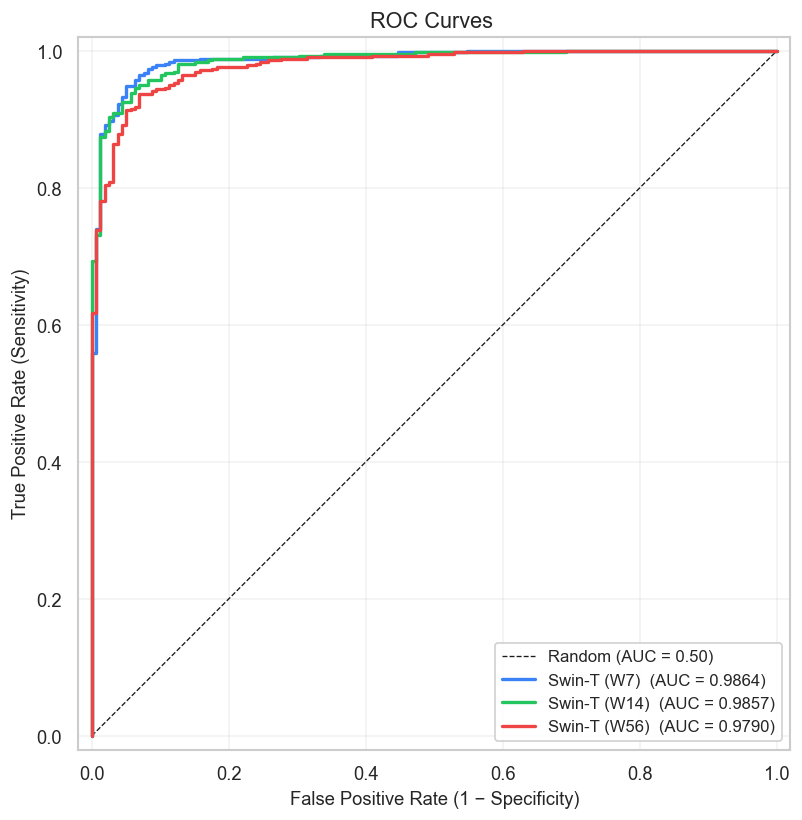

In [30]:
fig, ax = plt.subplots(figsize=(8, 7))

# Diagonal (random classifier)
ax.plot([0, 1], [0, 1], "k--", linewidth=0.8, label="Random (AUC = 0.50)")

for name, r in results.items():
    fpr, tpr, _ = roc_curve(r["targets"], r["probs"])
    roc_auc = auc(fpr, tpr)
    ls = "-"
    ax.plot(fpr, tpr, ls, linewidth=2, label=f"{name}  (AUC = {roc_auc:.4f})",
            color=MODEL_CONFIGS[name]["color"])

ax.set_xlabel("False Positive Rate (1 − Specificity)")
ax.set_ylabel("True Positive Rate (Sensitivity)")
ax.set_title("ROC Curves ")
ax.legend(loc="lower right", framealpha=0.9)
ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)
ax.set_aspect("equal")
ax.grid(True, alpha=0.25)

fig.tight_layout()
fig.savefig(IMAGE_DIR + "roc_curves.png", bbox_inches="tight")
plt.show()

---
## 5. VRAM Memory Analysis

In theory, Swin's local-window attention scales as $\mathcal{O}(n)$ with image size, while global attention (as in ViT or our W56 configuration) scales as $\mathcal{O}(n^2)$. Proving this scaling law rigorously would require testing at multiple resolutions that is not the aim of this experiment; 

This experiment uses a single resolution (224 × 224) and therefore measures the absolute memory cost of each window configuration, not the scaling curve itself.

However, the results are striking: at fixed resolution and batch size, the choice of window size has a dramatic impact on memory consumption:

| Model | Batch Size | Measured VRAM (MB) |
|:---|:---:|---:|
| Swin-T (W7) | 32 | 2 695 |
| Swin-T (W14) | 32 | 3 839 |
| Swin-T (W56) | 32 | 21 068 |

### Interpreting the growth

From the Swin paper, the cost of window-based multi-head self-attention is:

$$\Omega(\text{W-MSA}) = 4hwC^{2} + 2M^{2}hwC$$

The first term ($4hwC^2$) covers linear projections (Q, K, V, output) and is **constant** regardless of window size. The second term ($2M^2hwC$) is the actual attention cost and grows with $M^2$.

If total VRAM were purely quadratic in $M$, we would have expected expected W14 ($M^2 = 196$) to use 4 the VRAM of W7 ($M^2 = 49$), and W56 ($M^2 = 3{,}136$) to use 64. The measured ratios are far smaller:

| Ratio | Expected (pure $M^2$) | Measured |
|:---|:---:|:---:|
| W14 / W7 | 4.0× | 1.43× |
| W56 / W7 | 64.0× | 7.82× |

This is because total VRAM would be the sum of a large constant (projections, MLP, patch-merging layers, stored activations for backprop, etc.) with the $M^2$-dependent attention cost. At small window sizes the constant floor dominates, masking the quadratic growth. Only at W56, where $M^2$ is 64× larger, does the attention term become large enough to visibly inflate total memory.

In short: the attention-specific memory cost grows quadratically with window size, but the total VRAM appears sub-linear because most memory is consumed by components that do not depend on $M$.

FOllowing this reasoning, the result'd be more evident with larger windows size, requireing of course bigger resolution images.

### In practice

Swin-T (W56) requires ≈ 7.8 more VRAM than W7, while delivering worse classification performance. This shows that global attention is not only unnecessary for this task, but actively wasteful: local windows achieve better accuracy with a fraction of the memory budget.


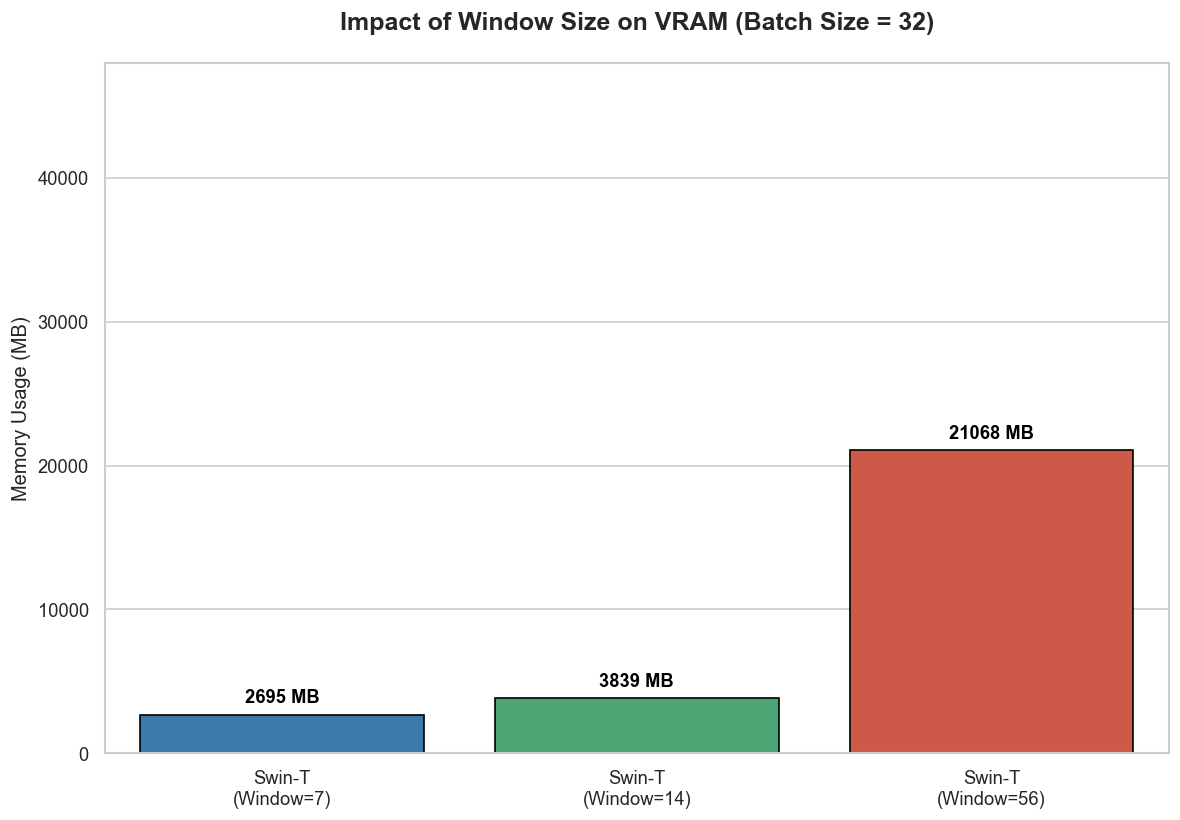

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

model_names = list(MODEL_CONFIGS.keys())
measured_mb  = [2695, 3839, 21068]
batch_sizes  = [32,   32,   32]

data = {
    'Configuration': ['Swin-T\n(Window=7)', 'Swin-T\n(Window=14)', 'Swin-T\n(Window=56)'],
    'VRAM (MB)': [2695, 3839, 21068],
    'Batch Size': [32, 32, 32],
    'Type': ['Standard', 'Intermediate', 'Explosion']
}
df = pd.DataFrame(data)

# Styling Setup
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 7))

custom_palette = ["#2b7bba", "#3cb371", "#e34a33"]

ax = sns.barplot(
    data=df,
    x='Configuration',
    y='VRAM (MB)',
    hue='Configuration',
    palette=custom_palette,
    dodge=False,
    edgecolor="black",
    linewidth=1
)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)} MB',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=11, fontweight='bold', color='black',
                xytext=(0, 5),
                textcoords='offset points')

plt.title('Impact of Window Size on VRAM (Batch Size = 32)', fontsize=15, fontweight='bold', pad=20)
plt.ylabel('Memory Usage (MB)', fontsize=12)
plt.xlabel('') # Remove redundant x-label
plt.ylim(0, 48000) # Give some headroom for text
plt.tight_layout()

# Remove the legend since x-axis is already labeled
if ax.get_legend():
    ax.get_legend().remove()

plt.show()

---
## 6 · Inference Latency Benchmark

Single-image (batch=1) forward pass, averaged over 50 repetitions after a 10-iteration warmup.

### Theoretical complexity

As already said previously, the Swin paper gives the computational cost of one attention layer as:

$$\Omega(\text{W-MSA}) = 4hwC^2 + 2M^2 hwC$$

where $h \times w$ is the number of patches in the feature map, $C$ is the embedding dimension, and $M$ is the window size.

- The first term ($4hwC^2$) covers the linear projections (Q, K, V, output) and is constant across window sizes.
- The second term ($2M^2 hwC$) is the attention computation and grows with $M^2$.

For our 224 × 224 images with patch size 4, the first stage has $h \times w = 56 \times 56 = 3\,136$ patches. The attention cost scales as:

| Configuration | $M$ | $M^2$ | Relative attention cost |
|:---|:---:|:---:|:---:|
| Swin-T (W7) | 7 | 49 | 1× |
| Swin-T (W14) | 14 | 196 | 4× |
| Swin-T (W56) | 56 | 3 136 | 64× |

### In practice

Based on the formula, we would expect W7 < W14 < W56 in latency. The actual measurements confirm the large gap for W56, but show an unexpected result: W14 is slighlty faster than W7. 

This may be explained by how GPU internally handle parallelism where fewer and larger matrix operations are more efficient (hardware dependent operation). Yet the general trend is confirmed.


In [ ]:
def measure_inference_speed(window_size: int, img_size: int = 224, repetitions: int = 50, batch_size: int = 1) -> tuple[float, float]:
    """Return (FPS, latency_ms) for a single forward pass."""

    args = SwinArgs()
    args.cfg = "../configs/swin/chest_xray_finetune.yaml"
    args.opts = [
        "DATA.IMG_SIZE", str(img_size),
        "MODEL.SWIN.WINDOW_SIZE", str(window_size),
        "MODEL.NUM_CLASSES", "2",
    ]
    if not os.path.exists(args.cfg):
        args.cfg = "configs/swin/chest_xray_finetune.yaml"

    config = get_config(args)
    config.defrost()
    config.DATA.IMG_SIZE = img_size
    config.MODEL.SWIN.WINDOW_SIZE = window_size
    config.freeze()

    model = build_model(config).to(DEVICE).eval()
    dummy = torch.randn(batch_size, 3, img_size, img_size, device=DEVICE)

    for _ in range(10):
        _ = model(dummy)
        if DEVICE.type == "mps":
            torch.mps.synchronize()
        elif DEVICE.type == "cuda":
            torch.cuda.synchronize()

    timings = []
    with torch.no_grad():
        for _ in range(repetitions):
            if DEVICE.type == "mps":
                torch.mps.synchronize()
            elif DEVICE.type == "cuda":
                torch.cuda.synchronize()

            t0 = time.perf_counter()
            _ = model(dummy)

            if DEVICE.type == "mps":
                torch.mps.synchronize()
            elif DEVICE.type == "cuda":
                torch.cuda.synchronize()

            timings.append(time.perf_counter() - t0)

    del model
    avg = np.mean(timings)
    return 1.0 / avg, avg * 1000

In [ ]:
# Run benchmark
speed_configs = [("Swin-T (W7)", 7), ("Swin-T (W14)", 14), ("Swin-T (W56)", 56)]

fps_list, ms_list, speed_names = [], [], []
print(f"{'Model':<18} {'FPS':>8} {'Latency':>10}")
print("─" * 40)

for name, ws in speed_configs:
    fps, ms = measure_inference_speed(ws)
    fps_list.append(fps)
    ms_list.append(ms)
    speed_names.append(name)
    print(f"{name:<18} {fps:>7.1f}  {ms:>8.2f} ms")

print("─" * 40)

Model                   FPS    Latency
────────────────────────────────────────
=> merge config from ../configs/swin/chest_xray_finetune.yaml
Swin-T (W7)           39.8     25.14 ms
=> merge config from ../configs/swin/chest_xray_finetune.yaml
Swin-T (W14)          48.0     20.85 ms
=> merge config from ../configs/swin/chest_xray_finetune.yaml
Swin-T (W56)          17.3     57.90 ms
────────────────────────────────────────


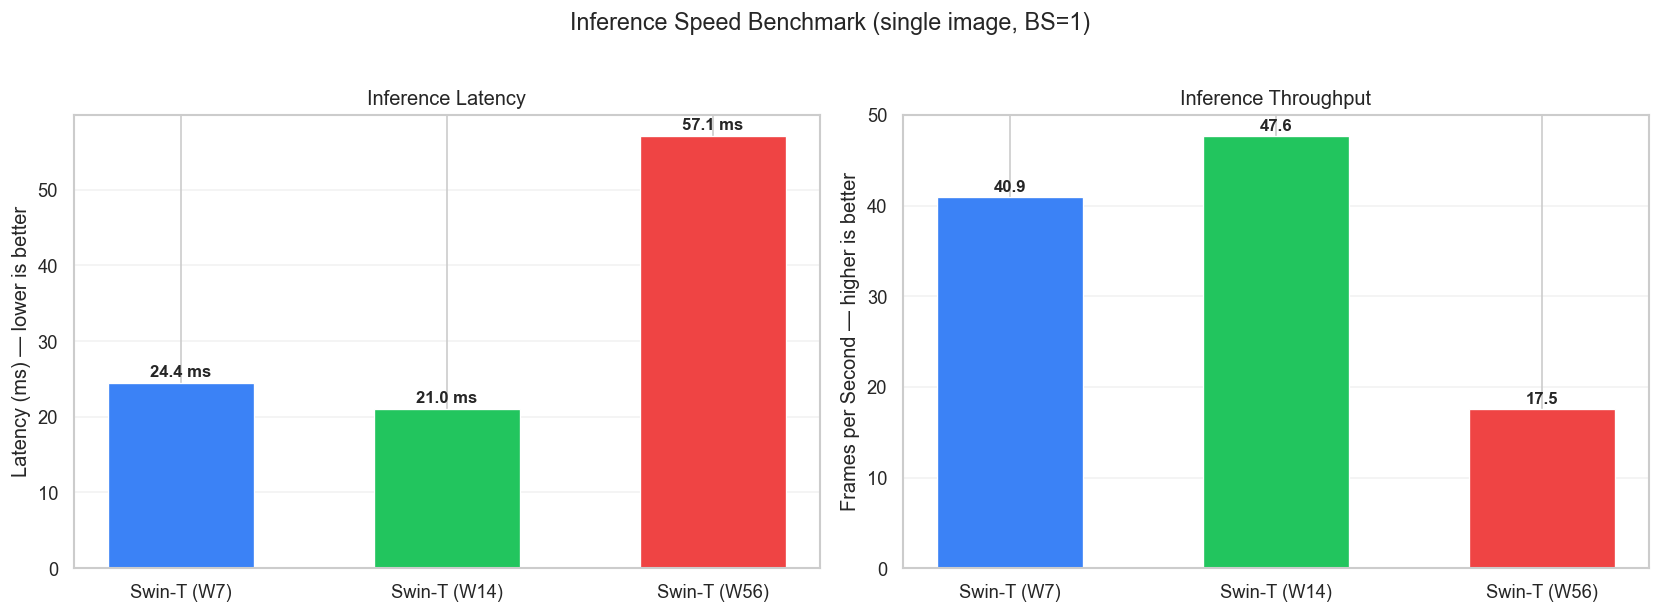


Swin-T (W56) is ≈ 2.3× slower than Swin-T (W7).


In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

colors = [MODEL_CONFIGS[n]["color"] for n in speed_names]
x = np.arange(len(speed_names))

# Latency
bars1 = ax1.bar(x, ms_list, 0.55, color=colors, edgecolor="white", linewidth=0.8)
for bar in bars1:
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
             f"{bar.get_height():.1f} ms", ha="center", va="bottom",
             fontsize=10, fontweight="bold")
ax1.set_ylabel("Latency (ms) — lower is better")
ax1.set_title("Inference Latency")
ax1.set_xticks(x)
ax1.set_xticklabels(speed_names)
ax1.grid(axis="y", alpha=0.25)

# Throughput (FPS)
bars2 = ax2.bar(x, fps_list, 0.55, color=colors, edgecolor="white", linewidth=0.8)
for bar in bars2:
    ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3,
             f"{bar.get_height():.1f}", ha="center", va="bottom",
             fontsize=10, fontweight="bold")
ax2.set_ylabel("Frames per Second — higher is better")
ax2.set_title("Inference Throughput")
ax2.set_xticks(x)
ax2.set_xticklabels(speed_names)
ax2.grid(axis="y", alpha=0.25)

fig.suptitle("Inference Speed Benchmark (single image, BS=1)", fontsize=14, y=1.02)
fig.tight_layout()
fig.savefig(IMAGE_DIR + "inference_speed.png", bbox_inches="tight")
plt.show()

speedup = ms_list[-1] / ms_list[0]
print(f"\nSwin-T (W56) is ≈ {speedup:.1f}× slower than Swin-T (W7).")

---
## 7. Multi-Axis Radar Comparison

A radar chart provides a holistic overview: accuracy, sensitivity, specificity, speed (normalized FPS), and memory efficiency (inverse of VRAM).

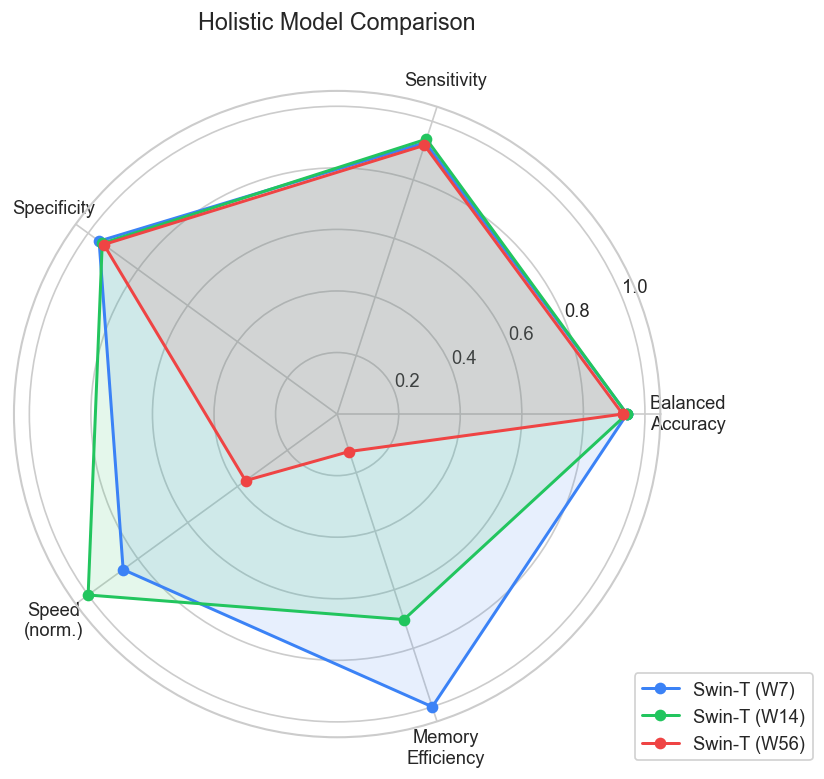

In [ ]:
_fps_map = dict(zip(speed_names, fps_list))
_mem_map = dict(zip(model_names, measured_mb))

categories = ["Balanced\nAccuracy", "Sensitivity", "Specificity", "Speed\n(norm.)", "Memory\nEfficiency"]
N = len(categories)


def make_radar_values(name):
    r = results[name]
    fps = _fps_map.get(name, 1.0)
    mem = _mem_map.get(name, 1.0)
    return [
        r["balanced_accuracy"],
        r["sensitivity"],
        r["specificity"],
        fps / max(fps_list),                     
        min(measured_mb) / mem,                  
    ]


angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # close the loop

fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

for name in results:
    vals = make_radar_values(name)
    vals += vals[:1]
    ax.plot(angles, vals, "o-", linewidth=1.8, label=name,
            color=MODEL_CONFIGS[name]["color"])
    ax.fill(angles, vals, alpha=0.12, color=MODEL_CONFIGS[name]["color"])

ax.set_thetagrids(np.degrees(angles[:-1]), categories)
ax.set_ylim(0, 1.05)
ax.set_title("Holistic Model Comparison", y=1.08, fontsize=14)
ax.legend(loc="lower right", bbox_to_anchor=(1.25, -0.05), framealpha=0.9)

fig.tight_layout()
fig.savefig(IMAGE_DIR + "radar_comparison.png", bbox_inches="tight")
plt.show()

---
## 8 · Summary Table

In [43]:
import pandas as pd

rows = []
for name in MODEL_CONFIGS:
    r = results.get(name, {})
    fps = _fps_map.get(name, None)
    mem = _mem_map.get(name, None)
    rows.append({
        "Model": name,
        "Accuracy (%)": f"{r.get('accuracy', 0) * 100:.2f}",
        "Bal. Accuracy (%)": f"{r.get('balanced_accuracy', 0) * 100:.2f}",
        "Sensitivity (%)": f"{r.get('sensitivity', 0) * 100:.2f}",
        "Specificity (%)": f"{r.get('specificity', 0) * 100:.2f}",
        "Latency (ms)": f"{1000 / fps:.1f}" if fps else "—",
        "VRAM (MB)": f"{mem}" if mem else "—",
    })

df = pd.DataFrame(rows).set_index("Model")
df.style.set_caption("Summary of all evaluation metrics")

,Accuracy (%),Bal. Accuracy (%),Sensitivity (%),Specificity (%),Latency (ms),VRAM (MB)
Model,,,,,,
Swin-T (W7),93.53,94.18,92.76,95.60,24.4,2695
Swin-T (W14),94.04,94.13,93.93,94.34,21.0,3839
Swin-T (W56),92.33,92.77,91.82,93.71,57.1,21068


---
## 9. Conclusions

**Key findings from the experiments:**

1. **W7 and W14 are essentially tied for best performance.** Swin-T (W7) achieves 94.18 % balanced accuracy with the highest specificity (95.60 %), while Swin-T (W14) achieves the highest raw accuracy (94.04 %) and the best sensitivity (93.93 %). The gap between them is within normal training variance, so neither is definitively superior. Both demonstrate that the Swin architecture transfers effectively from ImageNet to a completely different domain (medical imaging).

2. **Increasing window size beyond local does not guarantee better performance.** Swin-T (W56), which simulates global (ViT-like) attention, scores the lowest on every metric (92.33 % accuracy, 92.77 % balanced accuracy). This suggests that for 224 × 224 chest X-rays, a local receptive field in the first stage is already sufficient, and global attention mainly introduces noise from irrelevant spatial context. Locality is a beneficial inductive bias for this task.

3. **Global attention is not only weaker but dramatically more expensive.** W56 requires ≈ 7.8× more VRAM than W7 (21 GB vs 2.7 GB) and is ≈ 2.3× slower at inference (57.1 ms vs 24.4 ms). As discussed in Chapter 5, total VRAM is the sum of a large constant floor (projections, MLP, stored activations) plus an $M^2$ dependent attention cost. The attention-specific memory cost grows quadratically with window size, but the constant floor masks this at small $M$, which is why the overall ratio is 7.8× rather than the 64× predicted by pure $M^2$ scaling.

4. **FLOPs ≠ wall-clock speed.** In theory I'd have expectd W7 to be faster than W14 (since $M^2 = 49$ vs $196$), yet W14 is marginally faster in practice (21.0 ms vs 24.4 ms). This could a hardware-dependent effect.
What remains hardware-independent is the large gap between local and global attention: W56 is the slowest everywhere because at $M^2 = 3{,}136$ no amount of parallelism can compensate.

5. **Accuracy** All three models achieve both high sensitivity (>91%) and specificity (>93%), effectively closing the performance gap often seen in imbalanced datasets. Standard accuracy is an unreliable metric here, as it can be inflated by the class distribution (the dataset contains 2.6× more Pneumonia than Normal samples). A model biased toward the majority class could appear "accurate" overall while failing to identify the minority class.
Balanced Accuracy provides a truer reflection of performance by averaging recall across both classes. Furthermore, the prevalence of Pneumonia samples in the training set works to our advantage: it provides the model with a rich variety of pathological features, ensuring high Sensitivity. This aligns with the clinical objective, where the cost of a False Negative (missing a positive Pneumonia case) is significantly higher than that of a False Positive.


6. **ROC analysis confirms the ranking.** The ROC curves show that W7 and W14 achieve the highest AUC, meaning they have the best discriminative ability across all possible decision thresholds, not just the default argmax. The near-perfect AUC values suggest that all three models learn meaningful representations, but the gap reveals that local attention captures the relevant features more efficiently.

7. **Clinical perspective.** In a screening scenario, high sensitivity is paramount (we do not want to miss pneumonia), so all three models are viable. The differentiator is the efficiency–performance trade-off: W7 offers the lowest memory footprint and the best specificity (fewer false alarms for healthy patients); W14 offers the best sensitivity (fewest missed pneumonia cases) with marginally faster inference. The ROC curve allows a clinician to choose the optimal operating point based on their specific sensitivity/specificity requirements.

> Overall, the Swin-T architecture with **local window sizes** (W7 or W14) strikes the best balance between diagnostic performance, computational cost, and memory usage for chest X-ray classification. Global attention (W56) is worse on every axis: accuracy, memory, and speed, confirming that the shifted-window mechanism is allow a  better inductive bias for this domain.
